# Draft_02

**Course:** Advanced Topics in Deep Learning  
**Topic:** Generative Adversarial Networks (GANs)  
**Authors:** António Cruz (140129), Ricardo Kayseller (95813)

## Conditional GANs on MNIST: From DCGAN Baseline to Stable Conditional Training

### Project Goal
This notebook builds a **Conditional GAN (cGAN)** in **PyTorch** to generate MNIST digits (**0–9**) **conditioned on class labels**.  
Rath

### What We Are Building (High-Level)
We will train two neural networks in an adversarial setup:

- **Generator (G)**: transforms random noise `z` (and a label `y`) into a synthetic image `G(z, y)`.
- **Discriminator (D)**: receives an image `x` and (optionally) a label `y` and outputs a score indicating whether the pair looks **real** or **fake**.

In a **conditional** GAN, the label is part of the input so we can control the output class:
- “Generate a digit **7**” means we sample `z` and set `y=7`.

#### MNIST DataSet
MNIST is a standard benchmark for generative modeling:
- Images are **28×28**, **grayscale**, and have **10 classes** (digits 0–9).
- The dataset is simple enough to train quickly, but still supports meaningful experiments on:
  - **conditional control** (does `y` actually control the digit?),
  - **diversity** (do we avoid mode collapse?),
  - **training stability** (does the GAN converge reliably?).

#### Method Overview 
We will proceed in a structured way:

1. **Data + Preprocessing**
   - Load MNIST and normalize images to **[-1, 1]** (required when using **Tanh** at the generator output).

2. **Baseline: Unconditional DCGAN**
   - Train a standard DCGAN to validate the pipeline and establish a baseline.

3. **Baseline: Conditional GAN (cGAN)**
   - Adapt DCGAN into a cGAN by injecting the label `y` into:
     - **G** (noise + label),
     - **D** (image + label).

4. **Stability Improvements**
   - Apply a practical training recipe and stabilization techniques:
     - **TTUR** (different learning rates for D and G),
     - **Adam** settings commonly used for GANs,
     - **Spectral Normalization** (optional upgrade).

5. **Conditional Quality Upgrade**
   - Implement a stronger conditional discriminator:
     - **Projection Discriminator** (optional upgrade).

6. **Evaluation**
   - Qualitative: controlled sampling grids (fixed `z`, varying `y`, etc.).
   - Quantitative: **label-consistency** using a classifier (MNIST-specific and highly informative).


### 1. Libraries

In [1]:

# Standard library imports
import os
import json
import time
import random
from dataclasses import dataclass, asdict
from typing import Dict, Tuple, Optional, List

# Third-party imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# PyTorch + torchvision 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils import spectral_norm

import torchvision
from torchvision.utils import make_grid, save_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance

# Evaluation helpers 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


/home/ricarl/env/iscte/taap_p1/.venv_taap_p1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Sanity check: versions + device
print("Python deps loaded successfully.")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == "cuda":
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


Python deps loaded successfully.
torch: 2.10.0+cu130
torchvision: 0.25.0+cu130
numpy: 2.3.5
pandas: 3.0.0
Device: cuda
CUDA device: NVIDIA GeForce RTX 5090


#### 1.1 GPU acceleration configuration

In [3]:
# Automatic Mixed Precision (AMP)
use_amp = True

# cuDNN autotuner (speeds up conv layers for fixed input sizes)
torch.backends.cudnn.benchmark = True

# Enable TensorFloat-32 (TF32) on Ampere+ GPUs for faster matmul/conv (optional, safe for GANs)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
print("TF32 enabled for matmul and cuDNN.")

scaler = torch.amp.GradScaler("cuda", enabled=(use_amp and torch.cuda.is_available()))
print(f"AMP enabled: {use_amp and torch.cuda.is_available()}")

TF32 enabled for matmul and cuDNN.
AMP enabled: True


#### 1.2 DataLoader acceleration settings

In [4]:
NUM_WORKERS = 4          # CPU cores
PIN_MEMORY = True       # speeds up host->device transfer
PERSISTENT_WORKERS = True


### 2. Data Loading 

In [5]:
# Cell 1 — Global configuration
SEED = 42

# Dataset
DATASET_PATH = "../../dataset/"
NUM_CLASSES = 10

# Training
BATCH_SIZE = 256
LATENT_DIM = 100  # standard DCGAN-style latent dimension

# Step-based training schedule
NUM_STEPS = 15000
SAVE_INTERVAL = 1000

# Run naming
RUN_NAME = "CGAN_MNIST_EXP02"

# Output management
RUN_DIR = os.path.join("runs", RUN_NAME)
SAMPLES_DIR = os.path.join("samples", RUN_NAME)
CHECKPOINTS_DIR = os.path.join("checkpoints", RUN_NAME)

MODEL_OUTPUT_PATH = os.path.join("model", RUN_NAME)  # <- added (run-specific)
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)

os.makedirs(RUN_DIR, exist_ok=True)
os.makedirs(SAMPLES_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

D_MODEL_NAME = f"{RUN_NAME}_D"
G_MODEL_NAME = f"{RUN_NAME}_G"

# Evaluation
NUM_EVAL_SAMPLES = 10000

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility helper
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

print("Config loaded:")
print(f"RUN_NAME={RUN_NAME}")
print(f"DATASET_PATH={DATASET_PATH}")
print(f"Device={device}")
print(f"BATCH_SIZE={BATCH_SIZE} | LATENT_DIM={LATENT_DIM} | NUM_STEPS={NUM_STEPS} | SAVE_INTERVAL={SAVE_INTERVAL}")
print(f"RUN_DIR={RUN_DIR}")
print(f"SAMPLES_DIR={SAMPLES_DIR}")
print(f"CHECKPOINTS_DIR={CHECKPOINTS_DIR}")
print(f"MODEL_OUTPUT_PATH={MODEL_OUTPUT_PATH}")
print(f"NUM_EVAL_SAMPLES={NUM_EVAL_SAMPLES}")


Config loaded:
RUN_NAME=CGAN_MNIST_EXP02
DATASET_PATH=../../dataset/
Device=cuda
BATCH_SIZE=256 | LATENT_DIM=100 | NUM_STEPS=15000 | SAVE_INTERVAL=1000
RUN_DIR=runs/CGAN_MNIST_EXP02
SAMPLES_DIR=samples/CGAN_MNIST_EXP02
CHECKPOINTS_DIR=checkpoints/CGAN_MNIST_EXP02
MODEL_OUTPUT_PATH=model/CGAN_MNIST_EXP02
NUM_EVAL_SAMPLES=10000


In [6]:
# Transform: map [0,1] -> [-1,1] (required for Tanh in the Generator)
# (x - 0.5)/0.5 = 2x - 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset from local folder (set download=True if not present)
train_dataset = datasets.MNIST(
    root=DATASET_PATH,
    train=True,
    download=False,
    transform=transform
)

test_dataset = datasets.MNIST(
    root=DATASET_PATH,
    train=False,
    download=False,
    transform=transform
)

# DataLoader acceleration (GPU-friendly)
NUM_WORKERS = min(4, max(1, (os.cpu_count() or 2) - 1))
PIN_MEMORY = torch.cuda.is_available()
PERSISTENT_WORKERS = True if NUM_WORKERS > 0 else False

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT_WORKERS,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT_WORKERS,
    drop_last=False
)

# Sanity checks
x0, y0 = train_dataset[0]
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batches per epoch (train): {len(train_loader)}")
print(f"NUM_WORKERS={NUM_WORKERS} | PIN_MEMORY={PIN_MEMORY} | PERSISTENT_WORKERS={PERSISTENT_WORKERS}")
print(f"Example tensor shape: {x0.shape} (expected [1, 28, 28])")
print(f"Example tensor range: min={x0.min().item():.3f}, max={x0.max().item():.3f} (expected near [-1, 1])")
print(f"Example label: {y0}")

Training samples: 60000
Test samples: 10000
Batches per epoch (train): 234
NUM_WORKERS=4 | PIN_MEMORY=True | PERSISTENT_WORKERS=True
Example tensor shape: torch.Size([1, 28, 28]) (expected [1, 28, 28])
Example tensor range: min=-1.000, max=1.000 (expected near [-1, 1])
Example label: 5


### 3. Mini Data Understanding (MNIST)

#### 3.1 Mini data understanding: class distribution (train)

In [7]:
train_labels = train_dataset.targets.cpu().numpy()

classes, counts = np.unique(train_labels, return_counts=True)
freq = counts / counts.sum()

print("Train class distribution:")
for c, n, p in zip(classes, counts, freq):
    print(f"Digit {c}: {n:5d} ({p*100:5.2f}%)")

Train class distribution:
Digit 0:  5923 ( 9.87%)
Digit 1:  6742 (11.24%)
Digit 2:  5958 ( 9.93%)
Digit 3:  6131 (10.22%)
Digit 4:  5842 ( 9.74%)
Digit 5:  5421 ( 9.04%)
Digit 6:  5918 ( 9.86%)
Digit 7:  6265 (10.44%)
Digit 8:  5851 ( 9.75%)
Digit 9:  5949 ( 9.92%)


#### 3.2 Mini data understanding: plot class distribution

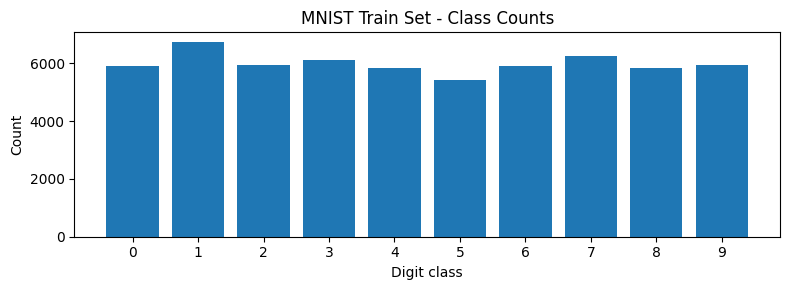

In [8]:
plt.figure(figsize=(8, 3))
plt.bar(classes, counts)
plt.xticks(classes)
plt.title("MNIST Train Set - Class Counts")
plt.xlabel("Digit class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### 3.3 Visualization: real MNIST samples (with de-normalization)

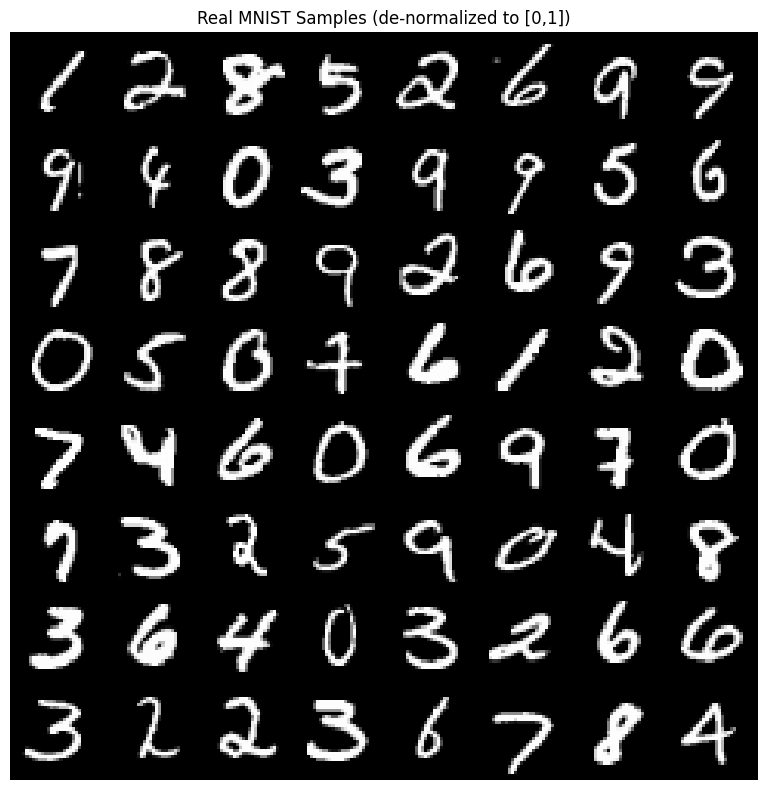

Saved: samples/real_mnist_grid.png


In [9]:
# Create output folder for figures
os.makedirs("samples", exist_ok=True)

# Fetch one batch
x_batch, y_batch = next(iter(train_loader))

# De-normalize from [-1,1] -> [0,1] for display
# If x_norm = (x - 0.5)/0.5, then x = (x_norm * 0.5) + 0.5
x_vis = (x_batch * 0.5) + 0.5
x_vis = x_vis.clamp(0.0, 1.0)

# Make a grid (e.g., 64 images)
n_show = 64
grid = make_grid(x_vis[:n_show], nrow=8, padding=2)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.title("Real MNIST Samples (de-normalized to [0,1])")
plt.tight_layout()
plt.show()

# Save figure for report
out_path = "samples/real_mnist_grid.png"
plt.imsave(out_path, grid.permute(1, 2, 0).cpu().numpy())
print(f"Saved: {out_path}")

### 4. Baseline: Unconditional DCGAN (Pipeline Validation)

#### 4.1 Model components: DCGAN Generator

In [10]:
class DCGANGenerator(nn.Module):
    """
    DCGAN-style Generator for MNIST (28x28, 1 channel).
    Input: latent vector z of shape [B, LATENT_DIM, 1, 1]
    Output: generated image of shape [B, 1, 28, 28] in [-1, 1] (Tanh)
    """
    def __init__(self, latent_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            # Input: (B, latent_dim, 1, 1)
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State: (B, 256, 7, 7)

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State: (B, 128, 14, 14)

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State: (B, 64, 28, 28)

            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
            # Output: (B, 1, 28, 28) in [-1, 1]
        )

    def forward(self, z):
        return self.net(z)


#### 4.2 Model components: DCGAN Discriminator

In [11]:
class DCGANDiscriminator(nn.Module):
    """
    DCGAN-style Discriminator for MNIST (28x28, 1 channel).
    Input: image [B, 1, 28, 28]
    Output: logits [B, 1] (NO Sigmoid here)
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 1)
            # NOTE: no Sigmoid
        )

    def forward(self, x):
        return self.net(x)

#### 4.3 DCGAN weight initialization (Normal(0, 0.02))

In [12]:
def weights_init_dcgan(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#### 4.4 Instantiate models + move to device

In [13]:
G = DCGANGenerator(latent_dim=LATENT_DIM).to(device)
D = DCGANDiscriminator().to(device)

G.apply(weights_init_dcgan)
D.apply(weights_init_dcgan)

print(G)
print(D)

DCGANGenerator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
DCGANDiscriminator(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4),

#### 4.4 DCGAN losses + optimizers (TTUR)

In [14]:

# AMP (new API) + logits-safe loss

use_amp = True
criterion = nn.BCEWithLogitsLoss()

print("AMP + criterion ready:")
print("use_amp =", use_amp)
print("criterion =", criterion)


AMP + criterion ready:
use_amp = True
criterion = BCEWithLogitsLoss()


In [15]:
# TTUR learning rates (good default for GANs)
LR_G = 1e-4
LR_D = 4e-4
BETAS = (0.5, 0.999)

opt_G = torch.optim.Adam(G.parameters(), lr=LR_G, betas=BETAS)
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D, betas=BETAS)

print(f"Optimizers ready | LR_G={LR_G} LR_D={LR_D} BETAS={BETAS}")
print(f"Loss: {criterion}")

Optimizers ready | LR_G=0.0001 LR_D=0.0004 BETAS=(0.5, 0.999)
Loss: BCEWithLogitsLoss()


#### 4.5 Sampling utilities (grid saving)

In [16]:
os.makedirs("samples/dcgan", exist_ok=True)

@torch.no_grad()
def sample_dcgan_grid(
    G: torch.nn.Module,
    step: int,
    device: torch.device,
    n_samples: int = 64,
    nrow: int = 8,
    out_dir: str = "samples/dcgan"
):
    """
    Generate a grid of samples from the unconditional DCGAN and save it to disk.

    Notes:
    - Generator output is in [-1, 1] (Tanh), so we de-normalize to [0, 1] for visualization.
    - The saved image is used for qualitative monitoring over time.
    """
    os.makedirs(out_dir, exist_ok=True)

    G.eval()
    z = torch.randn(n_samples, LATENT_DIM, 1, 1, device=device)
    fake = G(z)  # [-1, 1]

    # De-normalize to [0, 1] for display
    fake_vis = (fake * 0.5) + 0.5
    fake_vis = fake_vis.clamp(0.0, 1.0)

    grid = make_grid(fake_vis, nrow=nrow, padding=2)
    grid_np = grid.permute(1, 2, 0).cpu().numpy()

    out_path = os.path.join(out_dir, f"step_{step:06d}.png")
    plt.imsave(out_path, grid_np)

    G.train()
    return out_path, grid


#### 4.6 DCGAN training loop (step-based)

Training DCGAN (unconditional):   0%|          | 0/15000 [00:00<?, ?it/s]

[Step 0] Saved samples: samples/dcgan/step_000000.png


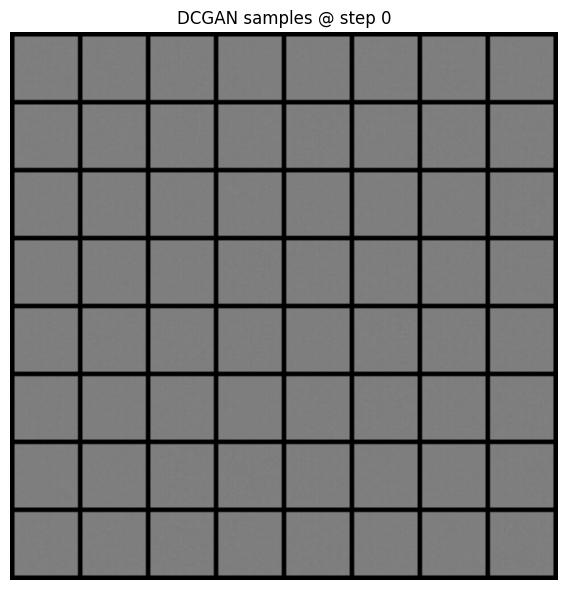

Training DCGAN (unconditional):   7%|▋         | 998/15000 [00:09<01:49, 127.87it/s]

[Step 1000] Saved samples: samples/dcgan/step_001000.png


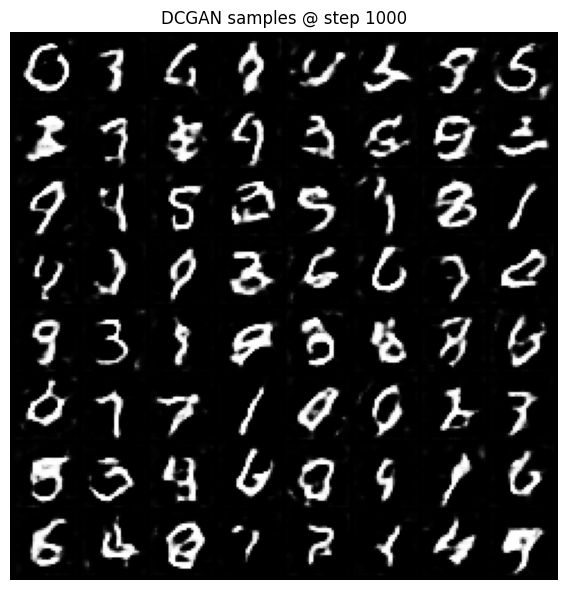

Training DCGAN (unconditional):  13%|█▎        | 1985/15000 [00:17<01:29, 145.49it/s]

[Step 2000] Saved samples: samples/dcgan/step_002000.png


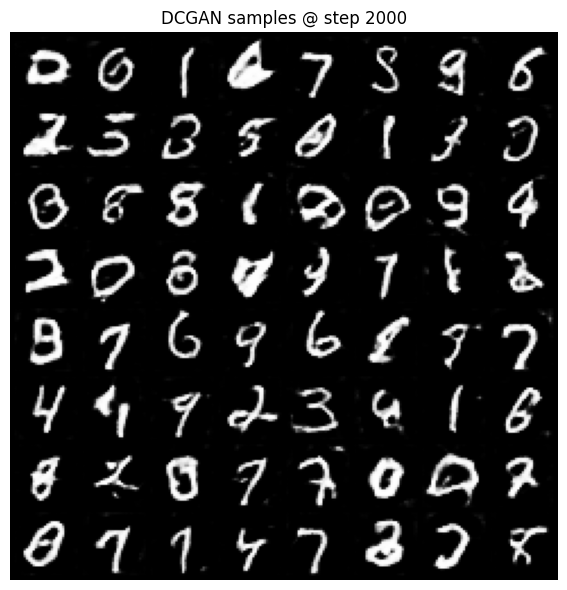

Training DCGAN (unconditional):  20%|█▉        | 2987/15000 [00:24<01:20, 148.39it/s]

[Step 3000] Saved samples: samples/dcgan/step_003000.png


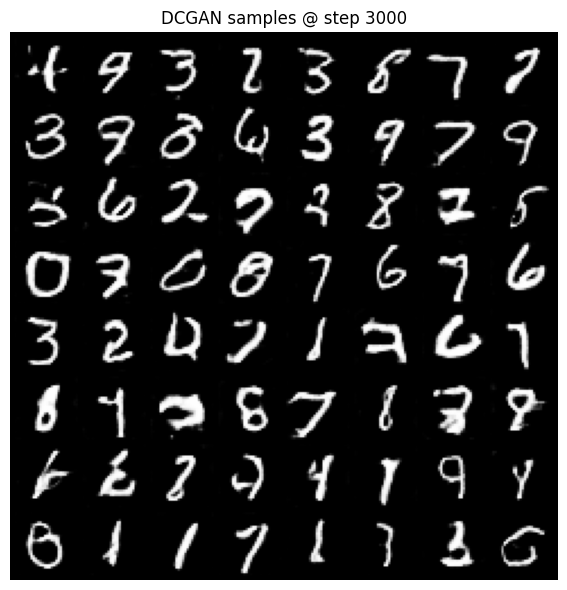

Training DCGAN (unconditional):  27%|██▋       | 3991/15000 [00:31<01:17, 141.31it/s]

[Step 4000] Saved samples: samples/dcgan/step_004000.png


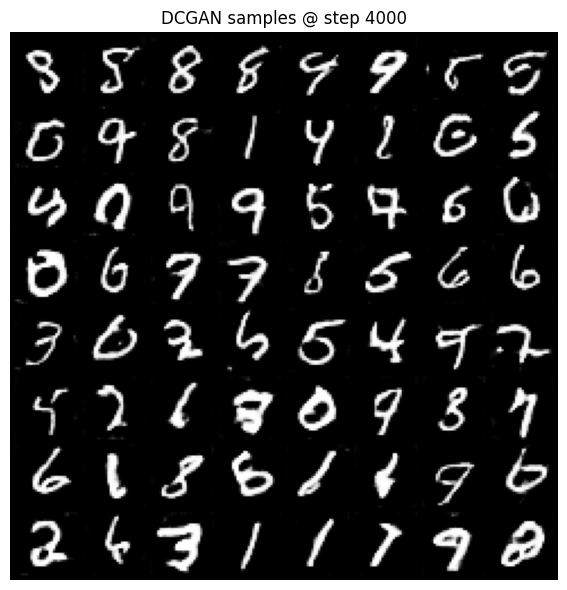

Training DCGAN (unconditional):  33%|███▎      | 4986/15000 [00:38<01:09, 143.20it/s]

[Step 5000] Saved samples: samples/dcgan/step_005000.png


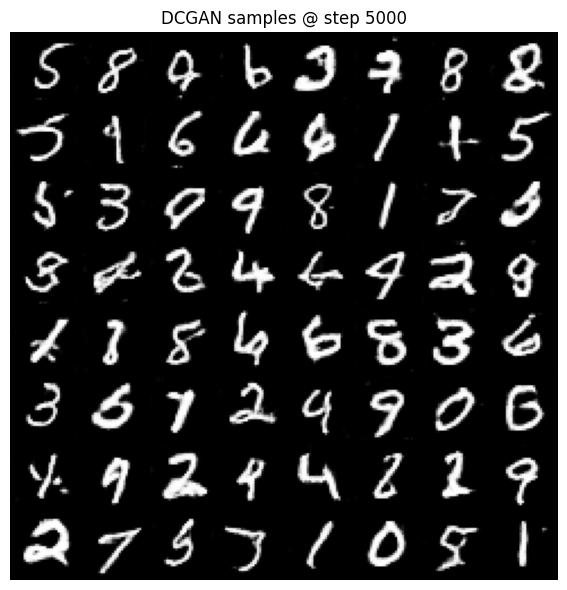

Training DCGAN (unconditional):  40%|███▉      | 5997/15000 [00:45<01:02, 143.53it/s]

[Step 6000] Saved samples: samples/dcgan/step_006000.png


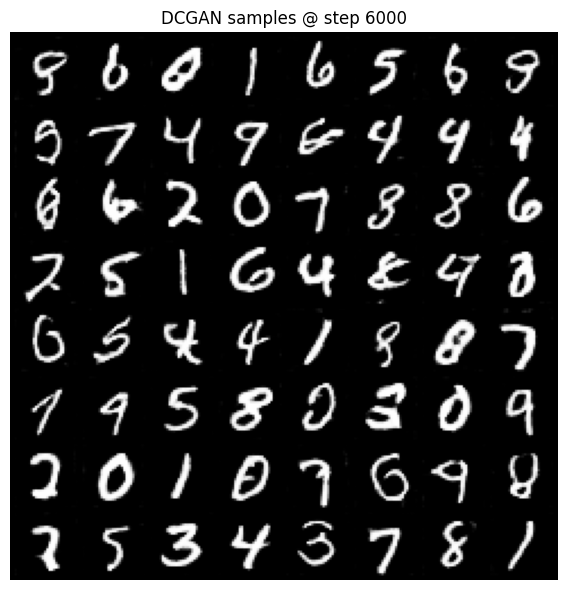

Training DCGAN (unconditional):  47%|████▋     | 6989/15000 [00:53<00:52, 151.78it/s]

[Step 7000] Saved samples: samples/dcgan/step_007000.png


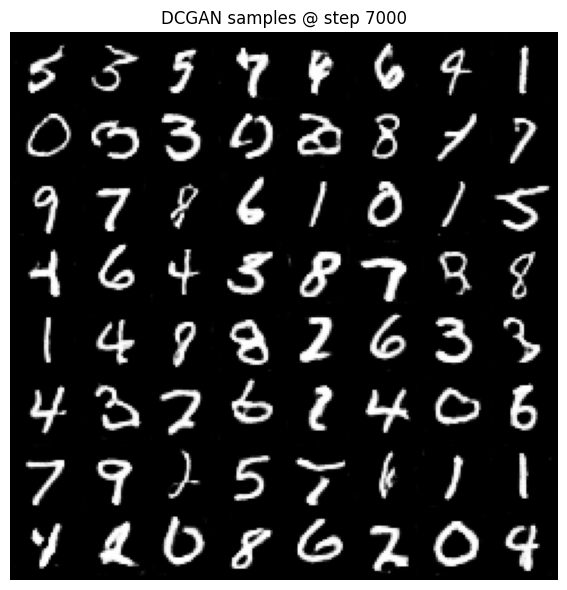

Training DCGAN (unconditional):  53%|█████▎    | 7991/15000 [01:00<00:46, 151.82it/s]

[Step 8000] Saved samples: samples/dcgan/step_008000.png


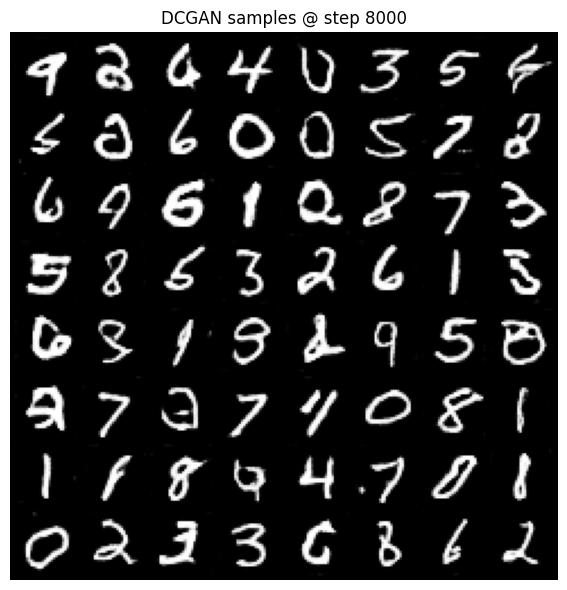

Training DCGAN (unconditional):  60%|█████▉    | 8991/15000 [01:07<00:42, 140.68it/s]

[Step 9000] Saved samples: samples/dcgan/step_009000.png


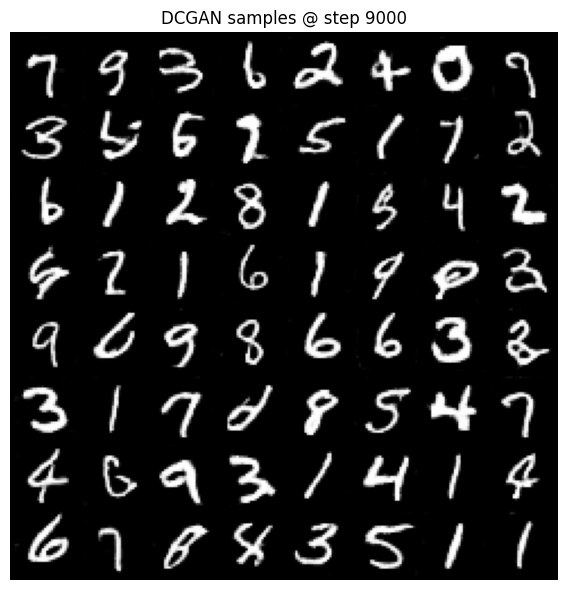

Training DCGAN (unconditional):  67%|██████▋   | 9987/15000 [01:14<00:34, 146.47it/s]

[Step 10000] Saved samples: samples/dcgan/step_010000.png


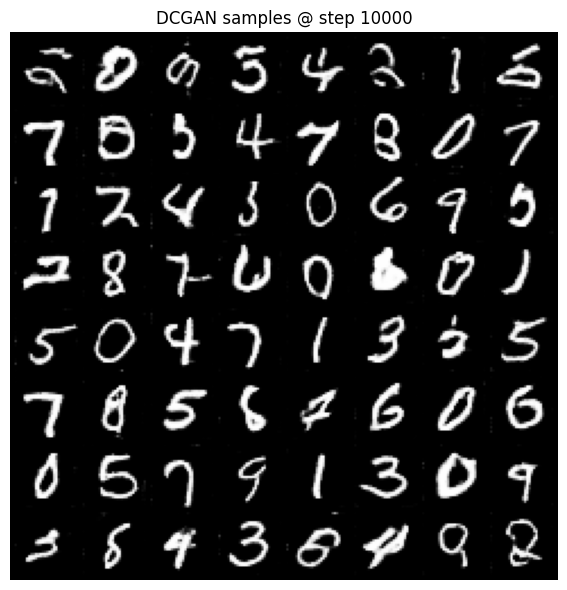

Training DCGAN (unconditional):  73%|███████▎  | 10999/15000 [01:24<00:32, 122.16it/s]

[Step 11000] Saved samples: samples/dcgan/step_011000.png


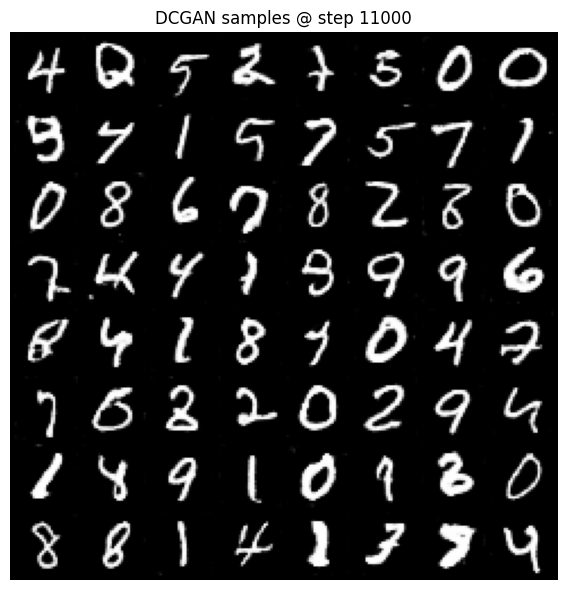

Training DCGAN (unconditional):  80%|███████▉  | 11997/15000 [01:31<00:20, 147.77it/s]

[Step 12000] Saved samples: samples/dcgan/step_012000.png


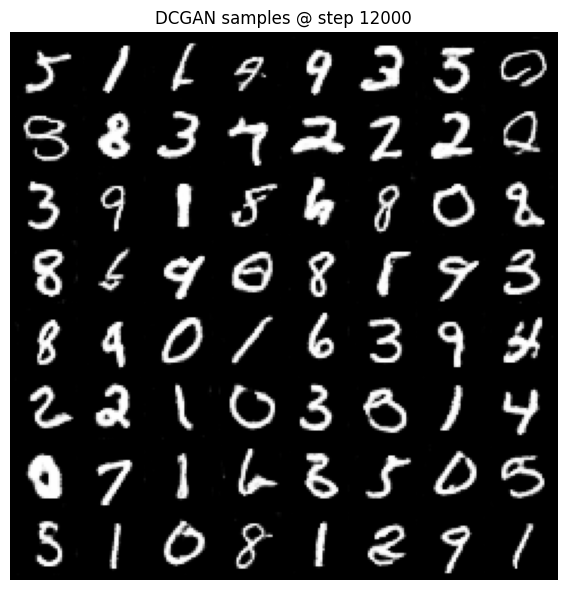

Training DCGAN (unconditional):  87%|████████▋ | 12993/15000 [01:38<00:13, 146.85it/s]

[Step 13000] Saved samples: samples/dcgan/step_013000.png


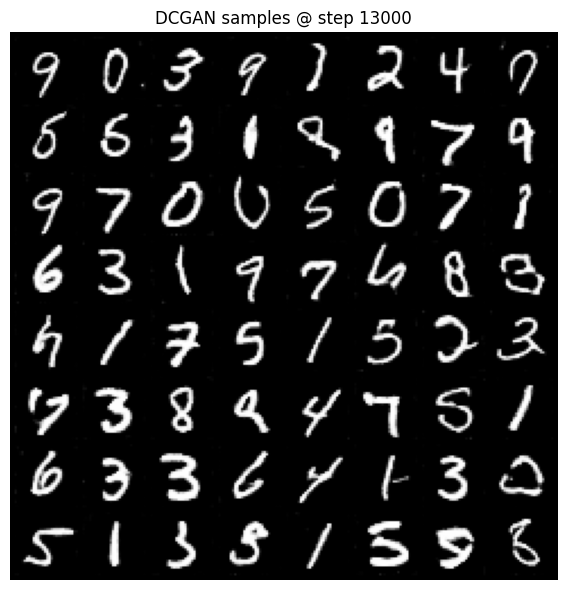

Training DCGAN (unconditional):  93%|█████████▎| 13986/15000 [01:45<00:07, 143.91it/s]

[Step 14000] Saved samples: samples/dcgan/step_014000.png


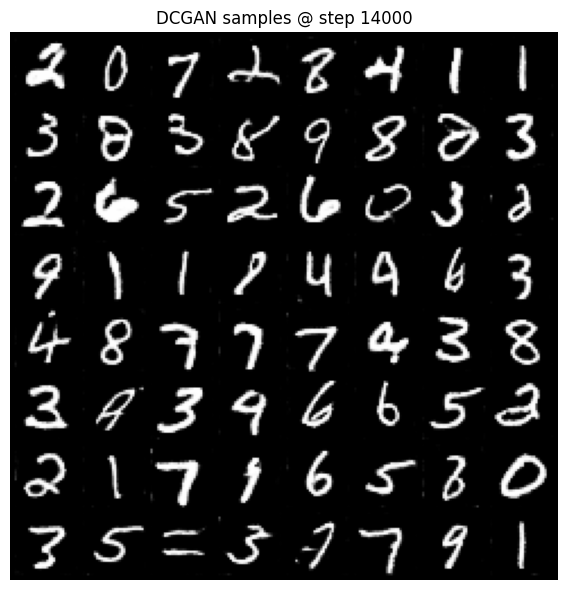

Training DCGAN (unconditional): 100%|██████████| 15000/15000 [01:52<00:00, 133.46it/s]

Saved log: runs/dcgan_unconditional_log.csv


step    loss_D    loss_G  D_real_prob_mean  D_fake_prob_mean
0     0  1.505018  1.195878          0.554688          0.586426
1    50  0.073989  4.654967          0.963867          0.035095
2   100  0.371645  2.738949          0.839355          0.164307
3   150  2.396634  4.539514          0.987793          0.882324
4   200  0.274238  2.638157          0.882324          0.130371

In [17]:

# DCGAN training loop (AMP-safe, logits-based) + monitoring + save+show grids

# Folders

os.makedirs("runs", exist_ok=True)
os.makedirs("samples/dcgan", exist_ok=True)

# Inline visualization helper

def show_grid_tensor(grid: torch.Tensor, title: str = ""):
    """
    Display a make_grid tensor inline.
    Expects grid of shape [C, H, W] in [0,1].
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

# Sampling function (save + return grid)

@torch.no_grad()
def sample_dcgan_grid(
    G: torch.nn.Module,
    step: int,
    device: torch.device,
    latent_dim: int,
    n_samples: int = 64,
    nrow: int = 8,
    out_dir: str = "samples/dcgan"
):
    """
    Generate a grid of samples from the unconditional DCGAN and save it to disk.
    Generator output is in [-1,1] so we de-normalize to [0,1] for visualization.
    Returns: (out_path, grid_tensor)
    """
    os.makedirs(out_dir, exist_ok=True)

    G.eval()
    z = torch.randn(n_samples, latent_dim, 1, 1, device=device)
    fake = G(z)  # [-1, 1]

    fake_vis = (fake * 0.5) + 0.5
    fake_vis = fake_vis.clamp(0.0, 1.0)

    grid = make_grid(fake_vis, nrow=nrow, padding=2)
    grid_np = grid.permute(1, 2, 0).cpu().numpy()

    out_path = os.path.join(out_dir, f"step_{step:06d}.png")
    plt.imsave(out_path, grid_np)

    G.train()
    return out_path, grid

# Real/fake labels

REAL_LABEL = 1.0
FAKE_LABEL = 0.0

# Training state

log_rows = []
global_step = 0

pbar = tqdm(total=NUM_STEPS, desc="Training DCGAN (unconditional)")

while global_step < NUM_STEPS:
    for real, _ in train_loader:
        if global_step >= NUM_STEPS:
            break

        real = real.to(device, non_blocking=True)
        B = real.size(0)

        real_targets = torch.full((B, 1), REAL_LABEL, device=device)
        fake_targets = torch.full((B, 1), FAKE_LABEL, device=device)

        # Train Discriminator
       
        opt_D.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda", enabled=(use_amp and device.type == "cuda")):
            out_real = D(real)  # logits
            loss_D_real = criterion(out_real, real_targets)

            z = torch.randn(B, LATENT_DIM, 1, 1, device=device)
            fake = G(z).detach()
            out_fake = D(fake)  # logits
            loss_D_fake = criterion(out_fake, fake_targets)

            loss_D = loss_D_real + loss_D_fake

        scaler.scale(loss_D).backward()
        scaler.step(opt_D)

        # Train Generator (non-saturating)

        opt_G.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda", enabled=(use_amp and device.type == "cuda")):
            z = torch.randn(B, LATENT_DIM, 1, 1, device=device)
            fake = G(z)
            out_fake_for_G = D(fake)  # logits

            # Non-saturating: push D(fake) logits toward "real"
            loss_G = criterion(out_fake_for_G, real_targets)

        scaler.scale(loss_G).backward()
        scaler.step(opt_G)
        scaler.update()

        # Logging (loss + D-score monitoring)

        if global_step % 50 == 0:
            with torch.no_grad():
                d_real_prob = torch.sigmoid(out_real).mean().item()
                d_fake_prob = torch.sigmoid(out_fake).mean().item()

            log_rows.append({
                "step": global_step,
                "loss_D": float(loss_D.detach().cpu().item()),
                "loss_G": float(loss_G.detach().cpu().item()),
                "D_real_prob_mean": d_real_prob,
                "D_fake_prob_mean": d_fake_prob,
            })

        # Sampling (save + inline display)
       
        if global_step % SAVE_INTERVAL == 0:
            out_path, grid = sample_dcgan_grid(
                G=G,
                step=global_step,
                device=device,
                latent_dim=LATENT_DIM,
                n_samples=64,
                nrow=8,
                out_dir="samples/dcgan"
            )
            print(f"[Step {global_step}] Saved samples: {out_path}")
            show_grid_tensor(grid, title=f"DCGAN samples @ step {global_step}")

        global_step += 1
        pbar.update(1)

pbar.close()

# Save logs

dcgan_log = pd.DataFrame(log_rows)
dcgan_log_path = "runs/dcgan_unconditional_log.csv"
dcgan_log.to_csv(dcgan_log_path, index=False)
print(f"Saved log: {dcgan_log_path}")

dcgan_log.head()


#### 4.7 DCGAN Plot: loss curves + discriminator score curves

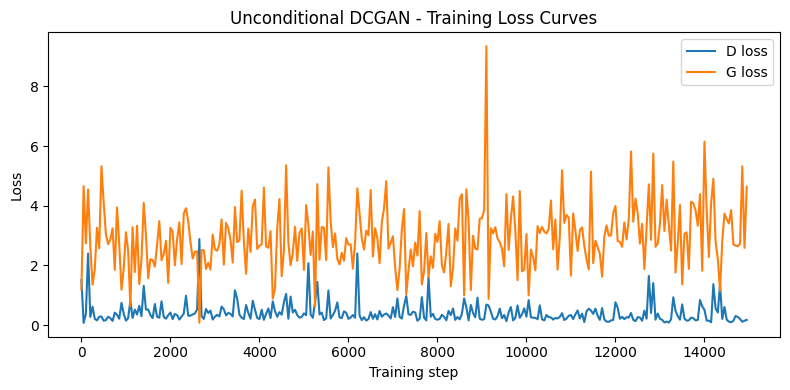

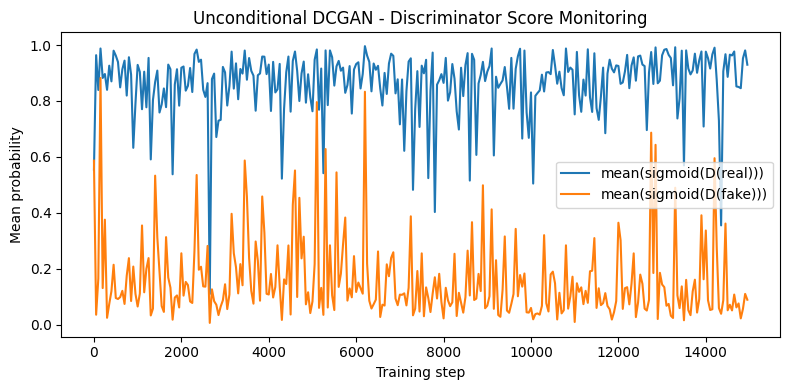

In [18]:
# 1) Loss curves
plt.figure(figsize=(8, 4))
plt.plot(dcgan_log["step"], dcgan_log["loss_D"], label="D loss")
plt.plot(dcgan_log["step"], dcgan_log["loss_G"], label="G loss")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Unconditional DCGAN - Training Loss Curves")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Discriminator score monitoring (interpretation-friendly)
# These are sigmoid(logits) means, so they behave like probabilities.
# - D_real_prob_mean should be higher than D_fake_prob_mean.
# - Over time, D_fake_prob_mean should increase as G improves.
if "D_real_prob_mean" in dcgan_log.columns and "D_fake_prob_mean" in dcgan_log.columns:
    plt.figure(figsize=(8, 4))
    plt.plot(dcgan_log["step"], dcgan_log["D_real_prob_mean"], label="mean(sigmoid(D(real)))")
    plt.plot(dcgan_log["step"], dcgan_log["D_fake_prob_mean"], label="mean(sigmoid(D(fake)))")
    plt.xlabel("Training step")
    plt.ylabel("Mean probability")
    plt.title("Unconditional DCGAN - Discriminator Score Monitoring")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("D-score columns not found. (Add D_real_prob_mean / D_fake_prob_mean to the training loop logging.)")

### 5. Stability Upgrade #1: Spectral Normalization (SNGAN-style)

**Motivation.** GAN training can become unstable when the Discriminator (D) becomes too sharp or too strong,
leading to oscillations or mode collapse. A practical and widely used stabilization technique is
**Spectral Normalization (SN)** applied to the Discriminator.

**What SN does.** Spectral Normalization constrains the spectral norm (largest singular value) of each
weight matrix, effectively limiting the Lipschitz constant of D. This helps prevent exploding gradients
and overly confident discriminator updates.

**Expected effect.**
- smoother training dynamics (reduced oscillations),
- reduced risk of mode collapse,
- more reliable conditional alignment (especially useful before moving to advanced cGAN variants).

**Experimental protocol.**
We keep everything fixed (seed, data, training schedule, TTUR hyperparameters) and compare:
1) **cGAN-concat baseline**
2) **cGAN-concat + SN in D**

#### 5.1 cGAN Generator and Discriminator (concat conditioning) + Spectral Norm variant

In [19]:

# Helpers

def one_hot(labels: torch.Tensor, num_classes: int) -> torch.Tensor:
    return F.one_hot(labels, num_classes=num_classes).float()

def make_label_map(labels: torch.Tensor, num_classes: int, height: int, width: int) -> torch.Tensor:
    y = one_hot(labels, num_classes).view(-1, num_classes, 1, 1)
    return y.expand(-1, num_classes, height, width)

def weights_init_dcgan(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find("Linear") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

# ---- cGAN Generator (concat z + one-hot y) ----
class CGANGeneratorConcat(nn.Module):
    def __init__(self, latent_dim: int, num_classes: int):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        in_channels = latent_dim + num_classes

        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 256, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        y_oh = one_hot(y, self.num_classes).to(z.device).view(-1, self.num_classes, 1, 1)
        zc = torch.cat([z, y_oh], dim=1)
        return self.net(zc)

# ---- cGAN Discriminator with Spectral Norm (concat image + label map) ----
class CGANDiscriminatorConcat_SN(nn.Module):
    """
    SN Discriminator: input channels = 1 (image) + 10 (label map) = 11
    Output: logits [B,1] (NO Sigmoid)
    """
    def __init__(self, num_classes: int):
        super().__init__()
        self.num_classes = num_classes
        in_channels = 1 + num_classes

        self.conv1 = spectral_norm(nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False))
        self.conv2 = spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False))
        self.conv3 = spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False))

        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.flatten = nn.Flatten()
        self.fc = spectral_norm(nn.Linear(256 * 3 * 3, 1))  # logits

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        y_map = make_label_map(y, self.num_classes, 28, 28).to(x.device)
        xc = torch.cat([x, y_map], dim=1)

        h = self.act(self.conv1(xc))
        h = self.act(self.conv2(h))
        h = self.act(self.conv3(h))

        h = self.flatten(h)
        return self.fc(h)  # logits



In [20]:
# ---- Instantiate ----
G_cgan = CGANGeneratorConcat(latent_dim=LATENT_DIM, num_classes=NUM_CLASSES).to(device)
D_cgan_sn = CGANDiscriminatorConcat_SN(num_classes=NUM_CLASSES).to(device)

# Weight init for G is standard; for SN D, init is OK but SN will normalize during training
G_cgan.apply(weights_init_dcgan)
D_cgan_sn.apply(weights_init_dcgan)

print("cGAN models ready:")
print("G_cgan:", type(G_cgan).__name__)
print("D_cgan_sn:", type(D_cgan_sn).__name__)

cGAN models ready:
G_cgan: CGANGeneratorConcat
D_cgan_sn: CGANDiscriminatorConcat_SN


In [21]:
# Helper: pick which discriminator to train in this run


# Option A: baseline cGAN concat discriminator (no SN)
# D_to_train = D_cgan

# Option B: SN discriminator
D_to_train = D_cgan_sn

print("Selected discriminator:", type(D_to_train).__name__)


Selected discriminator: CGANDiscriminatorConcat_SN


### 6. Training: cGAN-concat + Spectral Normalization (SN)

We now train the **conditional GAN** with:
- **Generator** conditioned by concatenating `z` with one-hot labels.
- **Discriminator** conditioned by concatenating the image with a label map.
- **Spectral Normalization** applied to all Conv/Linear layers of the Discriminator (SNGAN-style).

Monitoring focuses on:
- loss curves (diagnostic only),
- discriminator score trends,
- and, most importantly, conditional sample grids:
  - **fixed z, varying y=0..9** (control check)
  - **fixed y, varying z** (diversity check)

#### 6.1 Fixed-noise & fixed-label sets for consistent monitoring

In [ ]:
# Control check: SAME z, varying y=0..9
FIXED_Z_BASE = torch.randn(1, LATENT_DIM, 1, 1, device=device)
FIXED_Z = FIXED_Z_BASE.repeat(NUM_CLASSES, 1, 1, 1)

FIXED_Y = torch.arange(0, NUM_CLASSES, device=device, dtype=torch.long)  # MUST be 0..9

# Diversity check: SAME y, varying z
FIXED_CLASS = (FIXED_CLASS + 1) % NUM_CLASSES if "FIXED_CLASS" in globals() else 0
FIXED_Y_DIVERSITY = torch.full((64,), FIXED_CLASS, device=device, dtype=torch.long)
FIXED_Z_DIVERSITY = torch.randn(64, LATENT_DIM, 1, 1, device=device)

print("Fixed monitoring tensors ready.")
print("CONTROL | FIXED_Z:", FIXED_Z.shape, "| FIXED_Y:", FIXED_Y.tolist())
print("DIVERSITY | FIXED_Z_DIVERSITY:", FIXED_Z_DIVERSITY.shape, "| label:", FIXED_CLASS)


Diversity class: 0
Fixed monitoring tensors ready.
FIXED_Z: torch.Size([10, 100, 1, 1]) | FIXED_Y: torch.Size([10])
Diversity check: torch.Size([64, 100, 1, 1]) | label = 0


In [26]:
FIXED_Y

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

#### 6.2 Sampling utilities for cGAN (save + inline display)

In [23]:
def show_grid_tensor(grid: torch.Tensor, title: str = ""):
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def sample_cgan_control_grid(
    G: torch.nn.Module,
    step: int,
    device: torch.device,
    fixed_z: torch.Tensor,
    fixed_y: torch.Tensor,
    out_dir: str,
):
    """
    Control check: fixed z (one per class) and varying y=0..9.
    Generates a 1x10 row (or grid) showing class control.
    """
    os.makedirs(out_dir, exist_ok=True)
    G.eval()

    fake = G(fixed_z, fixed_y)  # [-1,1]
    fake_vis = (fake * 0.5) + 0.5
    fake_vis = fake_vis.clamp(0.0, 1.0)

    grid = make_grid(fake_vis, nrow=10, padding=2)
    grid_np = grid.permute(1, 2, 0).cpu().numpy()

    out_path = os.path.join(out_dir, f"control_step_{step:06d}.png")
    plt.imsave(out_path, grid_np)

    G.train()
    return out_path, grid

@torch.no_grad()
def sample_cgan_diversity_grid(
    G: torch.nn.Module,
    step: int,
    device: torch.device,
    fixed_z: torch.Tensor,
    fixed_y: torch.Tensor,
    out_dir: str,
    nrow: int = 8,
):
    """
    Diversity check: fixed class y (same label), varying z.
    Generates a grid (e.g., 8x8) to inspect intra-class diversity.
    """
    os.makedirs(out_dir, exist_ok=True)
    G.eval()

    fake = G(fixed_z, fixed_y)  # [-1,1]
    fake_vis = (fake * 0.5) + 0.5
    fake_vis = fake_vis.clamp(0.0, 1.0)

    grid = make_grid(fake_vis, nrow=nrow, padding=2)
    grid_np = grid.permute(1, 2, 0).cpu().numpy()

    out_path = os.path.join(out_dir, f"diversity_step_{step:06d}.png")
    plt.imsave(out_path, grid_np)

    G.train()
    return out_path, grid

#### 6.3 cGAN training loop (works for baseline D or SN D)

Training cGAN (concat + SN):   0%|          | 0/15000 [00:00<?, ?it/s]

[Step 1] Saved control grid: samples/CGAN_MNIST_EXP02/control_step_000001.png


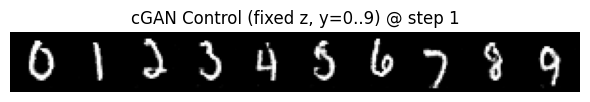

[Step 1] Saved diversity grid: samples/CGAN_MNIST_EXP02/diversity_step_000001.png


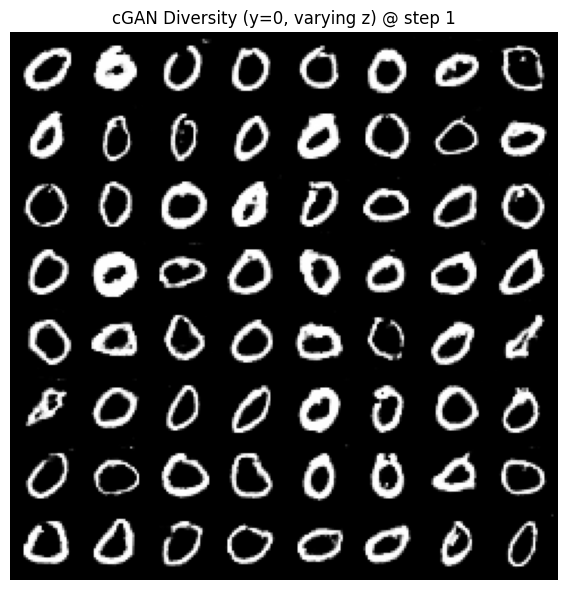

Training cGAN (concat + SN):   7%|▋         | 994/15000 [00:12<02:41, 86.47it/s]

[Step 1001] Saved control grid: samples/CGAN_MNIST_EXP02/control_step_001001.png


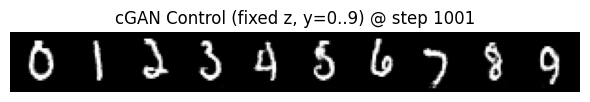

[Step 1001] Saved diversity grid: samples/CGAN_MNIST_EXP02/diversity_step_001001.png


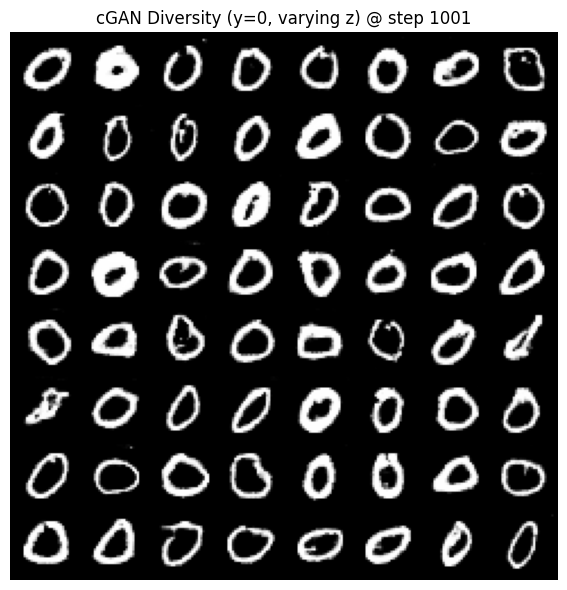

Training cGAN (concat + SN):  13%|█▎        | 1995/15000 [00:24<02:42, 80.24it/s]

[Step 2001] Saved control grid: samples/CGAN_MNIST_EXP02/control_step_002001.png


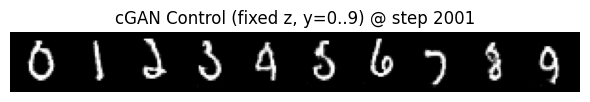

[Step 2001] Saved diversity grid: samples/CGAN_MNIST_EXP02/diversity_step_002001.png


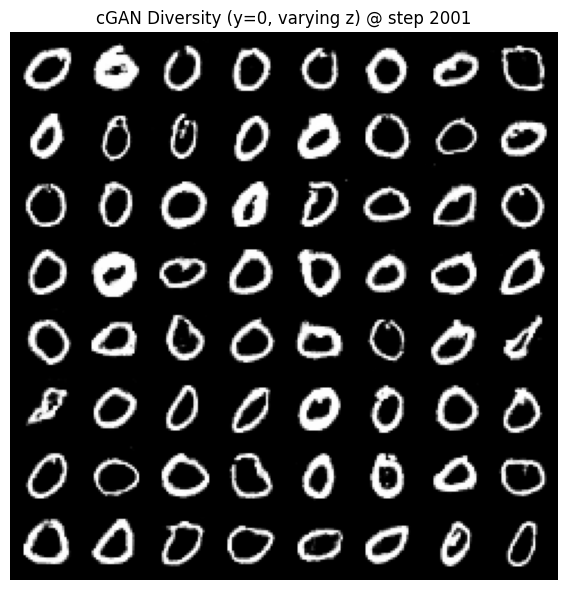

Training cGAN (concat + SN):  20%|██        | 3001/15000 [00:37<02:19, 85.82it/s]

[Step 3001] Saved control grid: samples/CGAN_MNIST_EXP02/control_step_003001.png


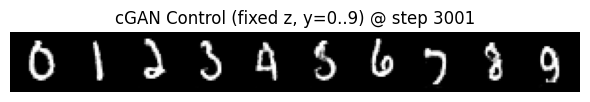

[Step 3001] Saved diversity grid: samples/CGAN_MNIST_EXP02/diversity_step_003001.png


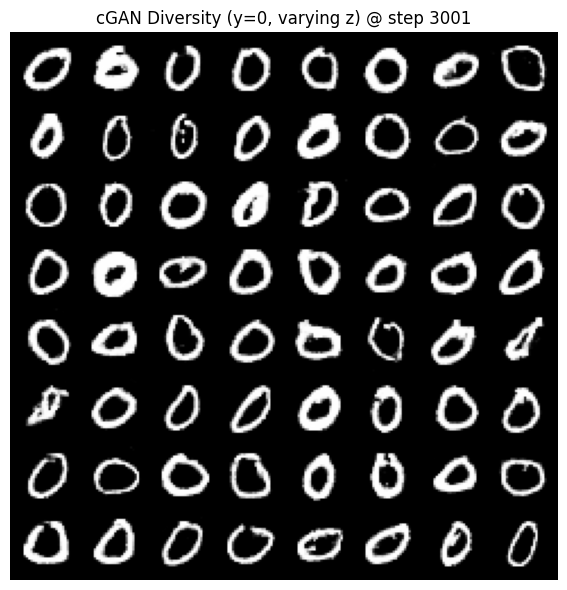

Training cGAN (concat + SN):  27%|██▋       | 3997/15000 [00:49<02:08, 85.53it/s]

[Step 4001] Saved control grid: samples/CGAN_MNIST_EXP02/control_step_004001.png


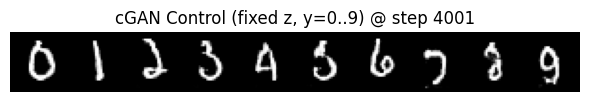

[Step 4001] Saved diversity grid: samples/CGAN_MNIST_EXP02/diversity_step_004001.png


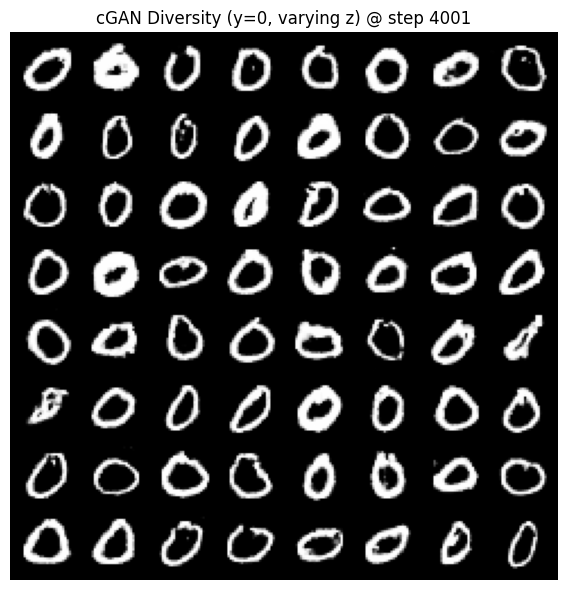

Training cGAN (concat + SN):  33%|███▎      | 4997/15000 [01:01<02:06, 79.29it/s]

[Step 5001] Saved control grid: samples/CGAN_MNIST_EXP02/control_step_005001.png


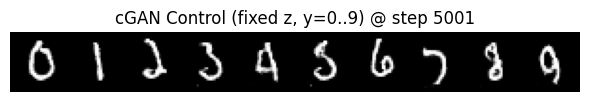

[Step 5001] Saved diversity grid: samples/CGAN_MNIST_EXP02/diversity_step_005001.png


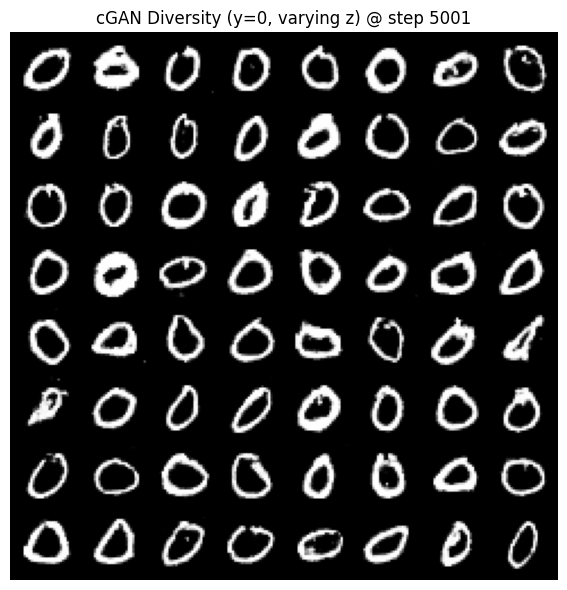

Training cGAN (concat + SN):  40%|████      | 6001/15000 [01:16<01:59, 75.22it/s]

[Step 6001] Saved control grid: samples/CGAN_MNIST_EXP02/control_step_006001.png


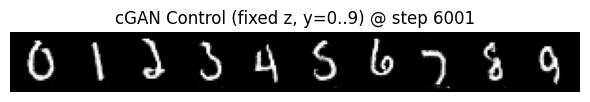

[Step 6001] Saved diversity grid: samples/CGAN_MNIST_EXP02/diversity_step_006001.png


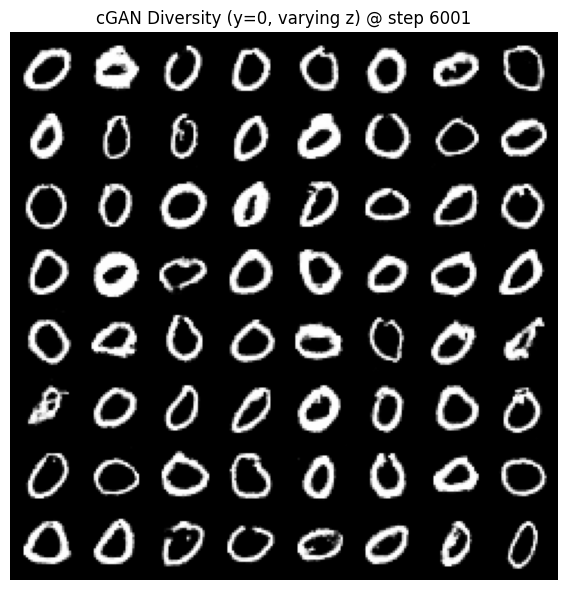

Training cGAN (concat + SN):  47%|████▋     | 6999/15000 [01:28<01:38, 81.32it/s]

[Step 7001] Saved control grid: samples/CGAN_MNIST_EXP02/control_step_007001.png


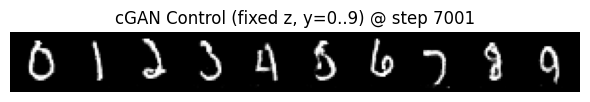

[Step 7001] Saved diversity grid: samples/CGAN_MNIST_EXP02/diversity_step_007001.png


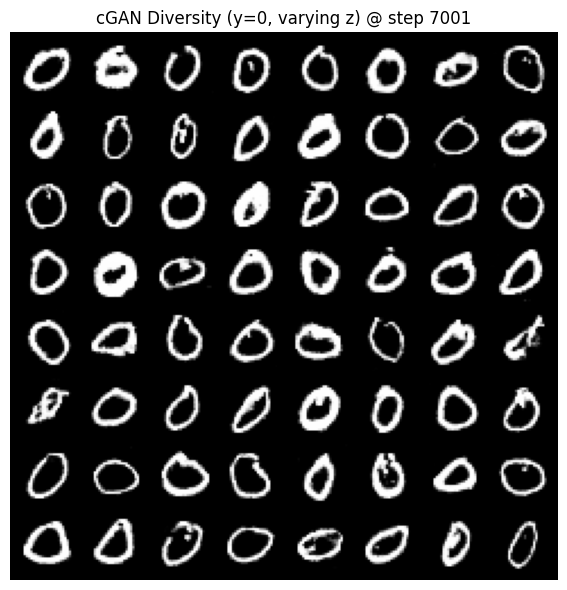

Training cGAN (concat + SN):  53%|█████▎    | 7993/15000 [01:42<01:34, 74.11it/s]

[Step 8001] Saved control grid: samples/CGAN_MNIST_EXP02/control_step_008001.png


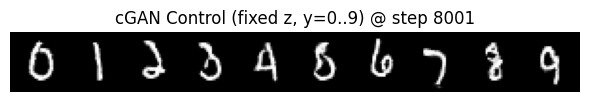

[Step 8001] Saved diversity grid: samples/CGAN_MNIST_EXP02/diversity_step_008001.png


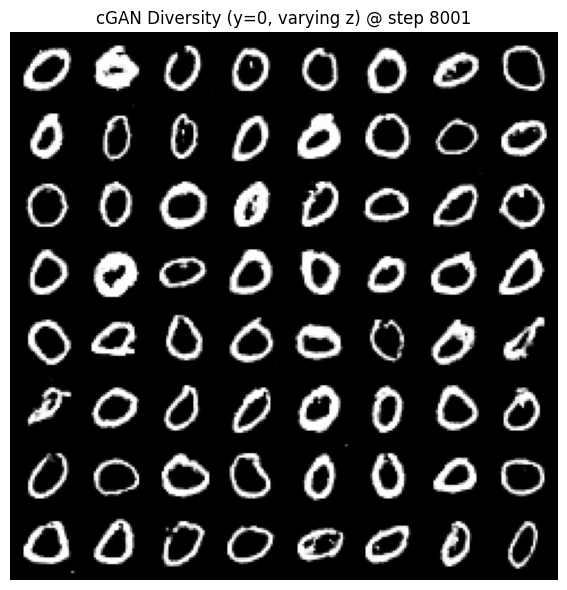

Training cGAN (concat + SN):  60%|█████▉    | 8996/15000 [01:53<01:06, 89.83it/s]

[Step 9001] Saved control grid: samples/CGAN_MNIST_EXP02/control_step_009001.png


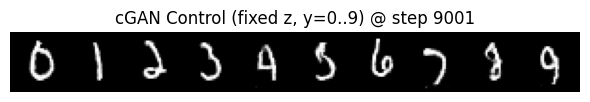

[Step 9001] Saved diversity grid: samples/CGAN_MNIST_EXP02/diversity_step_009001.png


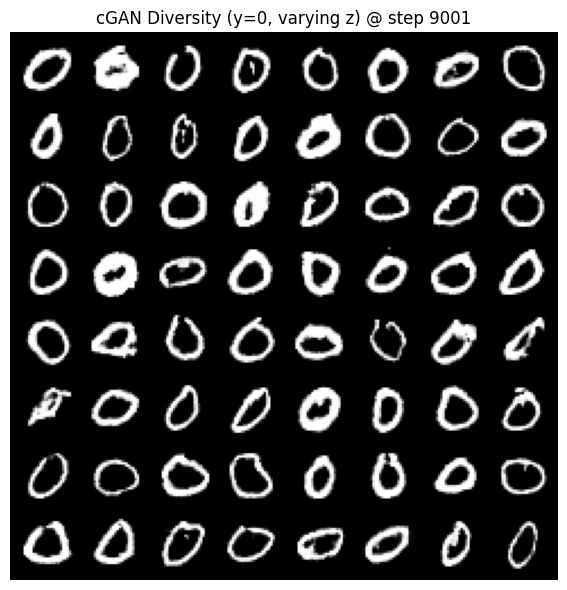

Training cGAN (concat + SN):  67%|██████▋   | 9994/15000 [02:06<01:03, 79.31it/s]

[Step 10001] Saved control grid: samples/CGAN_MNIST_EXP02/control_step_010001.png


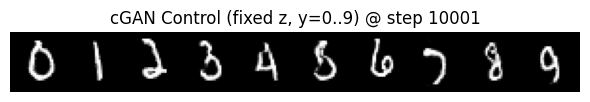

[Step 10001] Saved diversity grid: samples/CGAN_MNIST_EXP02/diversity_step_010001.png


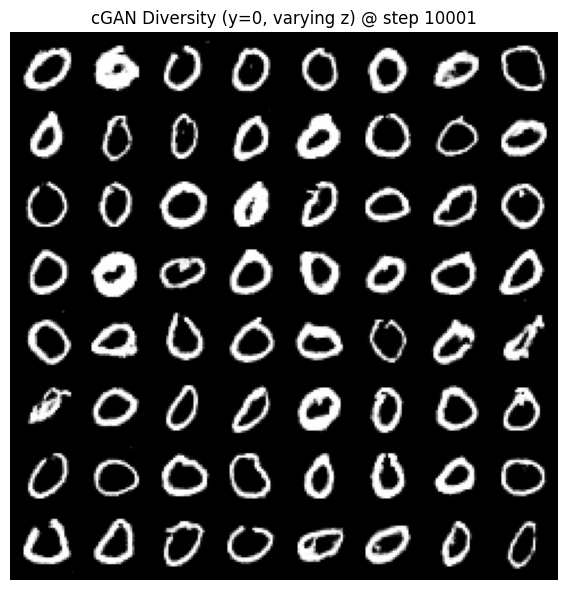

Training cGAN (concat + SN):  73%|███████▎  | 11000/15000 [02:19<00:48, 83.01it/s]

[Step 11001] Saved control grid: samples/CGAN_MNIST_EXP02/control_step_011001.png


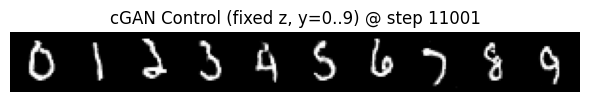

[Step 11001] Saved diversity grid: samples/CGAN_MNIST_EXP02/diversity_step_011001.png


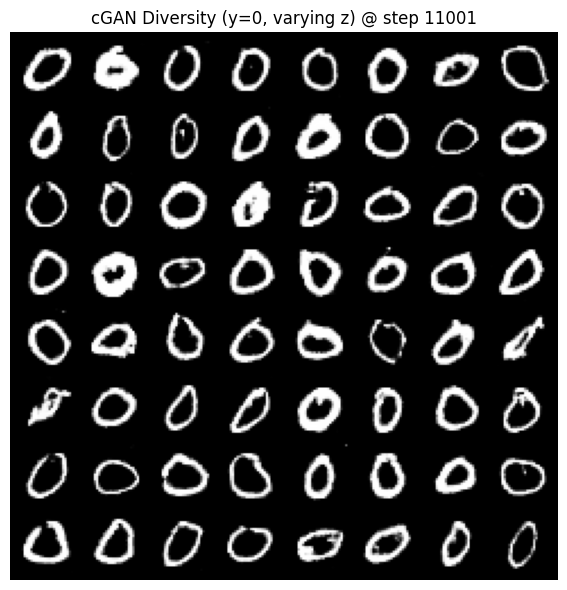

Training cGAN (concat + SN):  80%|████████  | 12000/15000 [02:31<00:34, 86.31it/s]

[Step 12001] Saved control grid: samples/CGAN_MNIST_EXP02/control_step_012001.png


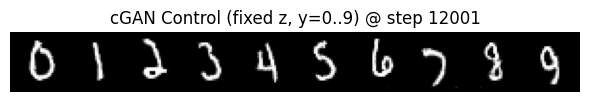

[Step 12001] Saved diversity grid: samples/CGAN_MNIST_EXP02/diversity_step_012001.png


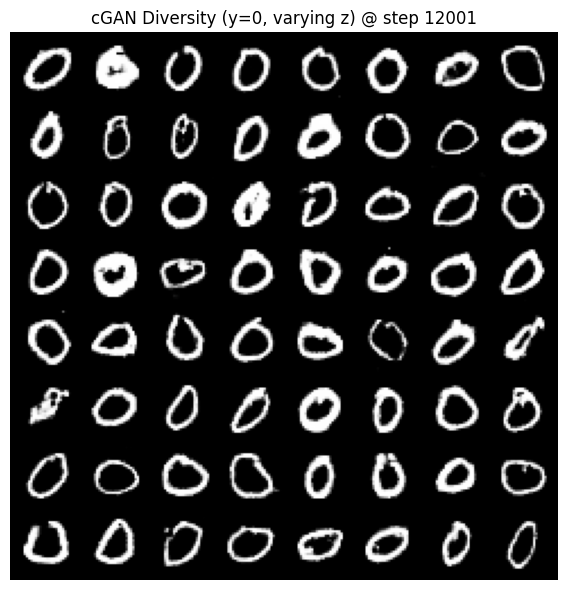

Training cGAN (concat + SN):  87%|████████▋ | 12999/15000 [02:43<00:24, 81.79it/s]

[Step 13001] Saved control grid: samples/CGAN_MNIST_EXP02/control_step_013001.png


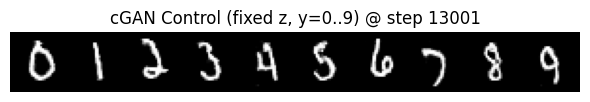

[Step 13001] Saved diversity grid: samples/CGAN_MNIST_EXP02/diversity_step_013001.png


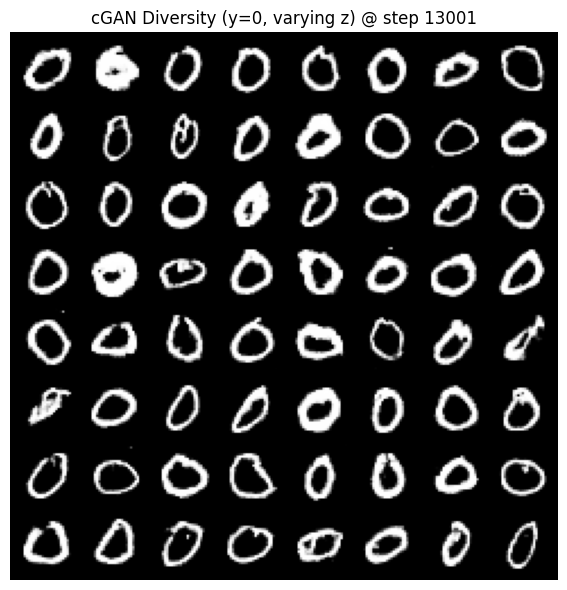

Training cGAN (concat + SN):  93%|█████████▎| 13999/15000 [02:57<00:11, 84.65it/s]

[Step 14001] Saved control grid: samples/CGAN_MNIST_EXP02/control_step_014001.png


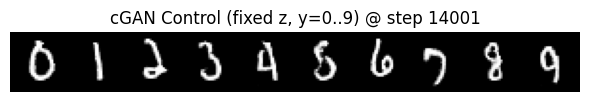

[Step 14001] Saved diversity grid: samples/CGAN_MNIST_EXP02/diversity_step_014001.png


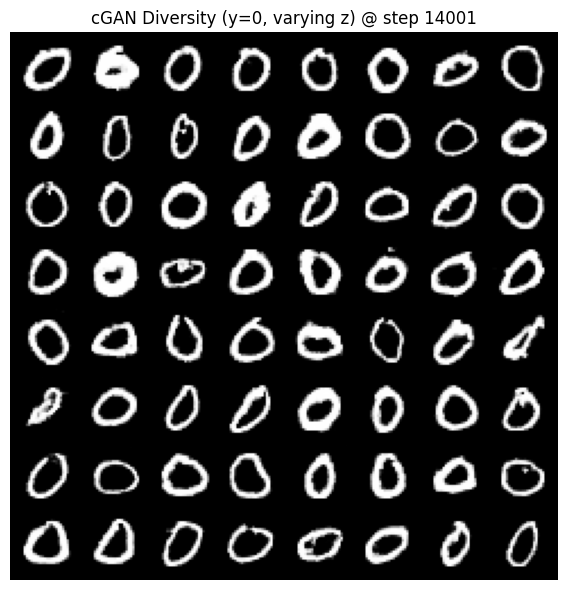

Training cGAN (concat + SN): 100%|██████████| 15000/15000 [03:09<00:00, 79.32it/s]

Saved log: runs/CGAN_MNIST_EXP02/cgan_concat_sn_log.csv


step    loss_D    loss_G  D_real_prob_mean  D_fake_prob_mean
0     0  1.378028  0.713959          0.509277          0.503418
1    50  1.378856  0.735163          0.495117          0.489990
2   100  1.387211  0.689078          0.500977          0.499268
3   150  1.394228  0.687503          0.509277          0.511719
4   200  1.376503  0.670757          0.522949          0.515625

In [28]:
# Choose which models to train (you already selected D_to_train = D_cgan_sn)
G_to_train = G_cgan
D_to_train = D_to_train  # CGANDiscriminatorConcat_SN

# Loss + TTUR optimizers (reuse your global setup if already defined)
criterion = nn.BCEWithLogitsLoss()

LR_G = 1e-4
LR_D = 4e-4
BETAS = (0.5, 0.999)

opt_G = torch.optim.Adam(G_to_train.parameters(), lr=LR_G, betas=BETAS)
opt_D = torch.optim.Adam(D_to_train.parameters(), lr=LR_D, betas=BETAS)

# AMP scaler (new API)
use_amp = True
scaler = torch.amp.GradScaler("cuda", enabled=(use_amp and torch.cuda.is_available()))

# Logging
log_rows = []
global_step = 0

pbar = tqdm(total=NUM_STEPS, desc="Training cGAN (concat + SN)")

while global_step < NUM_STEPS:
    for real, y in train_loader:
        if global_step >= NUM_STEPS:
            break

        real = real.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).long()
        B = real.size(0)

        real_targets = torch.ones((B, 1), device=device)
        fake_targets = torch.zeros((B, 1), device=device)

        # ----------------------
        # Train Discriminator
        # ----------------------
        opt_D.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda", enabled=(use_amp and device.type == "cuda")):
            # Real logits
            out_real = D_to_train(real, y)
            loss_D_real = criterion(out_real, real_targets)

            # Fake logits
            z = torch.randn(B, LATENT_DIM, 1, 1, device=device)
            fake = G_to_train(z, y).detach()
            out_fake = D_to_train(fake, y)
            loss_D_fake = criterion(out_fake, fake_targets)

            loss_D = loss_D_real + loss_D_fake

        scaler.scale(loss_D).backward()
        scaler.step(opt_D)

        # ----------------------
        # Train Generator (non-saturating)
        # ----------------------
        opt_G.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda", enabled=(use_amp and device.type == "cuda")):
            z = torch.randn(B, LATENT_DIM, 1, 1, device=device)
            fake = G_to_train(z, y)
            out_fake_for_G = D_to_train(fake, y)

            # Non-saturating: push D(fake|y) toward "real"
            loss_G = criterion(out_fake_for_G, real_targets)

        scaler.scale(loss_G).backward()
        scaler.step(opt_G)
        scaler.update()

        # ----------------------
        # Logging (loss + D-score monitoring)
        # ----------------------
        if global_step % 50 == 0:
            with torch.no_grad():
                d_real_prob = torch.sigmoid(out_real).mean().item()
                d_fake_prob = torch.sigmoid(out_fake).mean().item()

            log_rows.append({
                "step": global_step,
                "loss_D": float(loss_D.detach().cpu().item()),
                "loss_G": float(loss_G.detach().cpu().item()),
                "D_real_prob_mean": d_real_prob,
                "D_fake_prob_mean": d_fake_prob,
            })

        # ----------------------
        # Save + show conditional monitoring grids
        # ----------------------
        if global_step % SAVE_INTERVAL == 1:
            # Control: fixed z, varying y=0..9
            out_path_c, grid_c = sample_cgan_control_grid(
                G=G_to_train,
                step=global_step,
                device=device,
                fixed_z=FIXED_Z,
                fixed_y=FIXED_Y,
                out_dir=SAMPLES_DIR,
            )
            print(f"[Step {global_step}] Saved control grid: {out_path_c}")
            show_grid_tensor(grid_c, title=f"cGAN Control (fixed z, y=0..9) @ step {global_step}")

            # Diversity: fixed class, varying z
            out_path_d, grid_d = sample_cgan_diversity_grid(
                G=G_to_train,
                step=global_step,
                device=device,
                fixed_z=FIXED_Z_DIVERSITY,
                fixed_y=FIXED_Y_DIVERSITY,
                out_dir=SAMPLES_DIR,
                nrow=8
            )
            print(f"[Step {global_step}] Saved diversity grid: {out_path_d}")
            show_grid_tensor(grid_d, title=f"cGAN Diversity (y={FIXED_CLASS}, varying z) @ step {global_step}")

        global_step += 1
        pbar.update(1)

pbar.close()

# Save log
cgan_log = pd.DataFrame(log_rows)
cgan_log_path = os.path.join(RUN_DIR, "cgan_concat_sn_log.csv")
cgan_log.to_csv(cgan_log_path, index=False)
print(f"Saved log: {cgan_log_path}")

cgan_log.head()

#### 6.4 Plot: cGAN loss curves + discriminator score monitoring

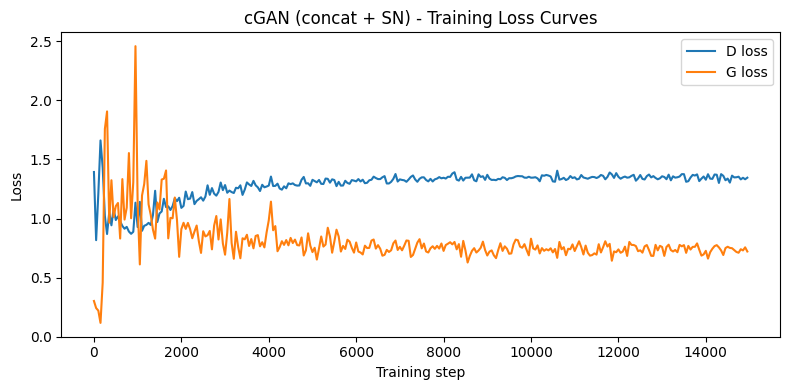

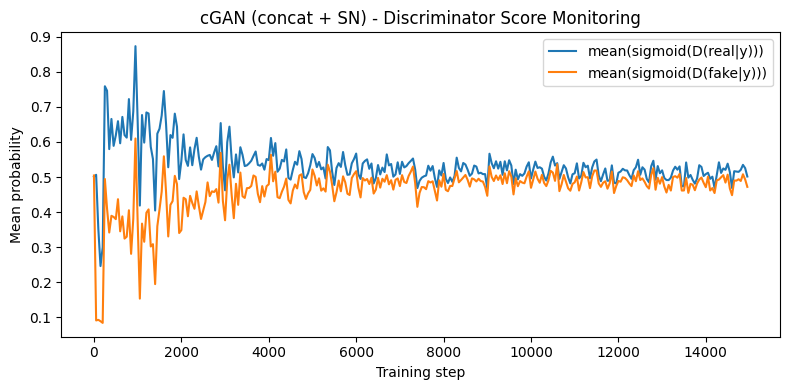

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(cgan_log["step"], cgan_log["loss_D"], label="D loss")
plt.plot(cgan_log["step"], cgan_log["loss_G"], label="G loss")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("cGAN (concat + SN) - Training Loss Curves")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(cgan_log["step"], cgan_log["D_real_prob_mean"], label="mean(sigmoid(D(real|y)))")
plt.plot(cgan_log["step"], cgan_log["D_fake_prob_mean"], label="mean(sigmoid(D(fake|y)))")
plt.xlabel("Training step")
plt.ylabel("Mean probability")
plt.title("cGAN (concat + SN) - Discriminator Score Monitoring")
plt.legend()
plt.tight_layout()
plt.show()